#**Использование классических ML-классификаторов для классификации текста**

#Название проекта:
**Разработка системы распознавания русскоязычного текста, сгенерированного LLM**

Область для которой будет реализован проект искусственного интеллекта и машинного обучения – образование.

**Актуальность** данной задачи обусловлена тем, что существующие в настоящее время популярные сервисы антиплагиата очень плохо  распознают сгенерированный русскоязычный текст.

**Цели проекта**
1.	Выявление отличий  в статистических  характеристиках русскоязычного текста написанного человеком,  и текста сгенерированного большими языковыми моделями.

2.	Создание системы распознавания русскоязычного текста сгенерированного большими языковыми моделями.


**В качестве данных** взяты  50 дипломных работ студентов специальности 09.02.07 "Информационные системы" объемом 40 – 50стр. выполненных в 2019 -2020гг,

и 50 дипломных работ студентов той же специальности объемом 40 – 50стр,  выполненных в 2024г.

##В основном датасете присутствуют следующие столбцы

**file_number**	- номер файла (1 - 100) Каждый файл представляет собой документ (дипломную работу студента в формате txt, очищенную от фрагментов программного кода и с удаленным экономическим разделом.)

**paragraph_number**	- номер абзаца в документе

**content**	- содержимое абзаца

**label** - метка класса

(0 - работа за 2019-2020гг.

1 - работа за 2024 г.)

## Работа с задачей естественного языка
--------

Будем работать следующим образом:

1. Проведем анализ данных и подготовку текста
2. Классификациия текста с помощью классических методов машинного обучения и метода векторизации текста TF-IDF
3. Классификация текста с помощью классических методов машинного обучения с использованием выделенных статистических признаков


In [ ]:
!pip -q install pymorphy2
!pip -q install sentencepiece
#!pip -q install transformers

#!gdown 1kD5QBEvBQCGaAzsYskIBCDo9sOeCwqKP
#!gdown 1N_eGBLKUuGzlL5dLzQvC4UfcZdZXf6eS


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.9 MB/s eta 0:00:00


In [ ]:
# основные по работе с данными (таблицы, математика)
import pandas as pd
import numpy as np

# обработка языка
import nltk # язык nlp
from nltk.corpus import stopwords
import string # строки
import re # регулярные выражения
import codecs # определяет базовые классы для стандартных кодировок Python
import pymorphy2 # русский язык

# графики
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5) # размер графиков
plt.style.use('fivethirtyeight') # стиль графиков

# модели
import sklearn

## 1. Предобработка текста
-------

На этом этапе мы проведем разведочный анализ текстов и первичную подготовку текста

In [ ]:
# Файл с данными 'oll_data.csv' https://drive.google.com/file/d/1HY6gQrFGE0zTRPOZDlRIuQNVFx_fonAT/view?usp=sharing
!gdown 1HY6gQrFGE0zTRPOZDlRIuQNVFx_fonAT

Downloading...
From: https://drive.google.com/uc?id=1HY6gQrFGE0zTRPOZDlRIuQNVFx_fonAT
To: /content/oll_data.csv
100% 7.92M/7.92M [00:00<00:00, 36.4MB/s]


In [ ]:
# Файл с данными 'train.csv'
df = pd.read_csv('oll_data.csv')

In [ ]:
df

,file_number,paragraph_number,content,label
0,1,1,Введение\n\n\n целью выпускной квалификаци...,0
1,1,2,Эти работы представлены ниже. Не стоит считать...,0
2,1,3,"В компьютерных играх, как правило, игровая сит...",0
3,1,4,"Сразу стоит отметить, что на сегодняшний день ...",0
4,1,5,"Вовторых, разработчики не прекращают своих экс...",0
...,...,...,...,...
5920,100,64,Под воздействием внешних условий они превращаю...,1
5921,100,65,В современных настольных пк таких компонентов ...,1
5922,100,66,"Стоимость таких услуг не велика, и это, безусл...",1
5923,100,67,Она может быть использована как пример для раз...,1


Убираем столбцы которые не будут участвовать в классификации

In [ ]:
df = df.drop(['file_number', 'paragraph_number'], axis=1)

In [ ]:
df

,content,label
0,Введение\n\n\n целью выпускной квалификаци...,0
1,Эти работы представлены ниже. Не стоит считать...,0
2,"В компьютерных играх, как правило, игровая сит...",0
3,"Сразу стоит отметить, что на сегодняшний день ...",0
4,"Вовторых, разработчики не прекращают своих экс...",0
...,...,...
5920,Под воздействием внешних условий они превращаю...,1
5921,В современных настольных пк таких компонентов ...,1
5922,"Стоимость таких услуг не велика, и это, безусл...",1
5923,Она может быть использована как пример для раз...,1


Переименовываем столбцы

In [ ]:
   df = df.rename(columns={'content': 'text'})

In [ ]:
df

,text,label
0,Введение\n\n\n целью выпускной квалификаци...,0
1,Эти работы представлены ниже. Не стоит считать...,0
2,"В компьютерных играх, как правило, игровая сит...",0
3,"Сразу стоит отметить, что на сегодняшний день ...",0
4,"Вовторых, разработчики не прекращают своих экс...",0
...,...,...
5920,Под воздействием внешних условий они превращаю...,1
5921,В современных настольных пк таких компонентов ...,1
5922,"Стоимость таких услуг не велика, и это, безусл...",1
5923,Она может быть использована как пример для раз...,1


Посмотрим есть ли дисбаланс классов

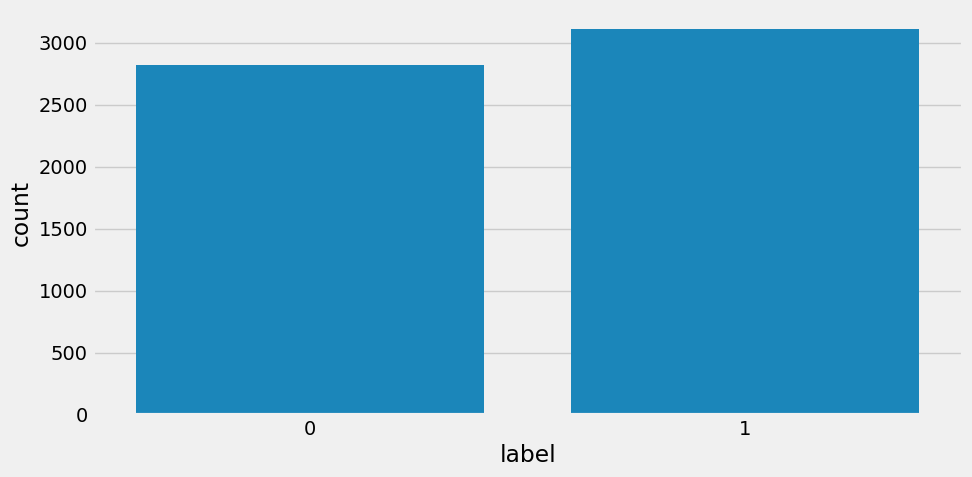

In [ ]:
x=df.groupby('label', as_index=False).count()
sns.countplot(x=df['label'])
plt.show()

In [ ]:
print(df.shape)
print(df[df['label']==1].shape)
print(df[df['label']==0].shape)



(5925, 2)
(3110, 2)
(2815, 2)


Дисбаланс классов есть, но совсем небольшой. Оставим как есть.

Визуализация распределений сообщений длинной больше 100 слов

<Axes: xlabel='len', ylabel='Density'>

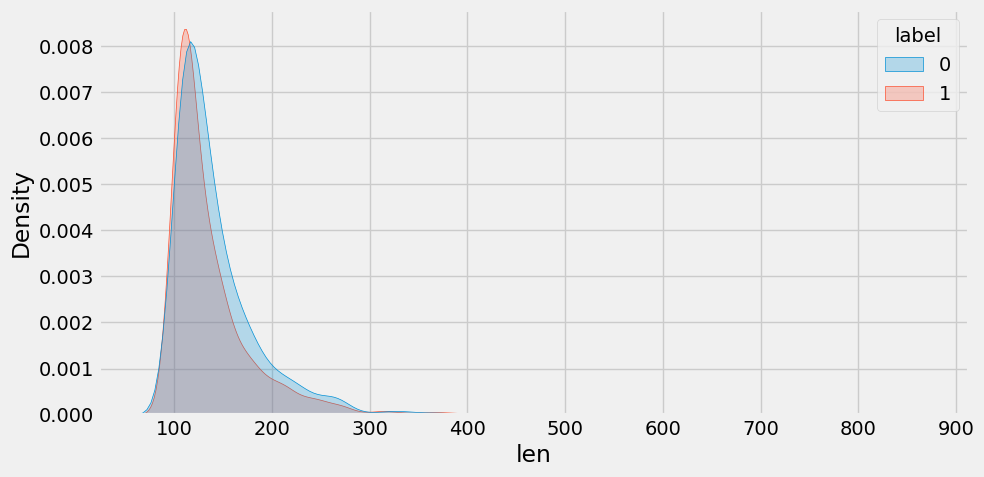

In [ ]:
df['len'] = df['text'].apply(lambda x: len(x.split(' ')))

max_words = df['len'].max()

mask = df['len']>100 # вектора слов

sns.kdeplot(x='len',
            hue='label',
            fill=True,
            data=df.loc[mask] )

In [ ]:
df.to_csv('ish_df.csv', index=False)

###  Очистка и подготовка текста
-----

Что будем делать?

Приводить к нижнему решистру, удалять символы (`[, :, ...`) и стоп-слова, а также проведем лемматизацию - то есть приведем слова в тексте к их нормальной форме

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pymorphy2
import re

In [ ]:
# Загрузка стоп-слов и инициализация лемматизатора
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Функция для предобработки текста
def preprocess_text(text):
    # Приведение к нижнему регистру и удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Токенизация и лемматизация
    tokens = text.split()
    lemmatized = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    return ' '.join(lemmatized)


In [ ]:
# Предобработка текста
df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,text,label,len,clean_text
0,Введение\n\n\n целью выпускной квалификаци...,0,188,введение цель выпускной квалификационный работ...
1,Эти работы представлены ниже. Не стоит считать...,0,73,работа представить ниже стоить считать предста...
2,"В компьютерных играх, как правило, игровая сит...",0,109,компьютерный игра правило игровой ситуация вос...
3,"Сразу стоит отметить, что на сегодняшний день ...",0,112,сразу стоить отметить сегодняшний день существ...
4,"Вовторых, разработчики не прекращают своих экс...",0,100,вовторое разработчик прекращать свой экспериме...


In [ ]:
df.to_csv('dataset_clean.csv')

## 2. Классификациия текста с помощью классических методов машинного обучения

-----

Для обучения будем пробовать основные модели машинного обучения, в качестве метрик предлагается использовать `accuracy` и `f1-score`

- Скорость
- Возможность анализа в реальном времени

In [ ]:
from sklearn.model_selection import train_test_split # делим на тестовую и тренировочную
from sklearn.feature_extraction.text import CountVectorizer # мешок слов


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report # метрика точности, f1 мера, матрица ошибок и отчёт по классификации
from sklearn import model_selection # выбор модели и оценка параметров (можно загрузить несколько моделей)
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # бустинг, случайный лес
from sklearn.svm import SVC # метод SVM, загружаем с ядром rbf https://scikit-learn.ru/1-4-support-vector-machines/
from sklearn.neighbors import KNeighborsClassifier # к ближайших соседей

In [ ]:
df = pd.read_csv('./dataset_clean.csv', index_col = 0)

In [ ]:
# Оставим только данные для обучения
df['text'] = df['clean_text']
df=df[['text', 'label']]

In [ ]:
df

,text,label
0,введение цель выпускной квалификационный работ...,0
1,работа представить ниже стоить считать предста...,0
2,компьютерный игра правило игровой ситуация вос...,0
3,сразу стоить отметить сегодняшний день существ...,0
4,вовторое разработчик прекращать свой экспериме...,0
...,...,...
5920,воздействие внешний условие превращаться орган...,1
5921,современный настольный пк такой компонент прак...,1
5922,стоимость такой услуга большой это безусловно ...,1
5923,использовать пример разработка аналогичный сис...,1


In [ ]:
df.to_csv('clean_df.csv', index=False)

## Test/Train разделение выборок

In [ ]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['label'],
                                                    test_size=test_size,
                                                    random_state=42)


In [ ]:
print(df.shape)
print(df[df['label']==1].shape)
print(df[df['label']==0].shape)

(5925, 2)
(3110, 2)
(2815, 2)


#  Bag of Words (Мешок слов) представление текста

**"Мешок слов"** - это метод представления текстовых данных в виде числовых векторов, которые могут быть использованы в алгоритмах машинного обучения.

Основная идея заключается в том, чтобы представить каждый документ (в вашем случае, текст) как вектор, где каждый элемент соответствует определенному слову из всего корпуса документов.

Вот как это работает:

**Создание словаря:**

Сначала создается словарь всех уникальных слов, встречающихся во всех документах обучающего набора.

**Кодирование документов:**

Каждый документ представляется в виде вектора той же длины, что и словарь.

Каждый элемент вектора соответствует частоте появления соответствующего слова в документе.

**Особенности:**

Игнорируется порядок слов в документе.
Учитывается только частота появления слов.

**Важные моменты:**

**Размерность**: Каждый вектор имеет размерность, равную количеству уникальных слов в словаре.

**Разреженность**: Большинство элементов в векторах будут нулевыми, так как не все слова встречаются в каждом документе.

**Потеря контекста**: Этот метод не учитывает порядок слов или их контекст в предложении.

**Простота**: Несмотря на свою простоту, этот метод часто дает хорошие результаты в задачах классификации текста.

In [ ]:
vectorizer = CountVectorizer() # мешок слов
X_train_coded = vectorizer.fit_transform(X_train) # вектора без контекста по тренировке
X_test_coded = vectorizer.transform(X_test) # вектора без контекста по тесту

In [ ]:
pd.DataFrame(X_test_coded.toarray().T)

,0,1,2,3,4,5,6,7,8,9,...,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Обучаем логистическую регрессию

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       0.84      0.81      0.82       882
           1       0.82      0.84      0.83       896

    accuracy                           0.83      1778
   macro avg       0.83      0.83      0.83      1778
weighted avg       0.83      0.83      0.83      1778



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def plot_confusion(y_test, y_pred):
    dict_normal_names={0: "Python",1:"DS"}
    data = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(data, columns=list(map(dict_normal_names.get, list(np.unique(y_test)))),
                                index = list(map(dict_normal_names.get, list(np.unique(y_test)))))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    #confusion matrix plot
    f, ax = plt.subplots(figsize=(4, 5))
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)

    sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                annot_kws={'size': 10})
    plt.title('Actuals vs Predicted')
    plt.show()

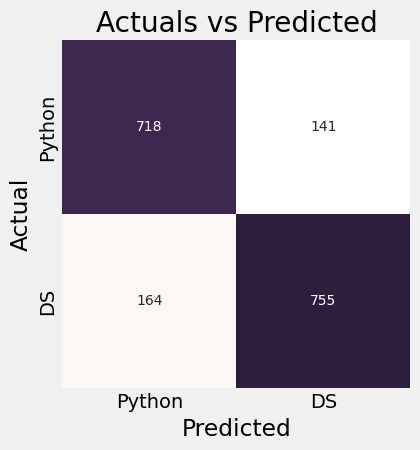

In [ ]:
plot_confusion(y_test, y_pred)

##Выводы:

**Логистическая регрессия на признаках "Мешок слов" позволила провести классификацию примерно с 80% точностью.**

То есть понятно, что выборки текстов за 2019г. и 2024 г. отличаются друг от друга составом слов.
Но имеет ли это какое либо отношение к использованию больших языковых моделей... это вопрос...

Возможно различие обусловлено другими причинами

**Можно лишь утверждать, что студенческие работы за 2019 г. отличаются от работ за 2024г. составом словаря, использованного студентами**

#  TF-IDF представление текста

**TF-IDF расшифровывается как "Term Frequency-Inverse Document Frequency"** (Частота термина - Обратная частота документа). Это статистическая мера, используемая для оценки важности слова в документе, являющемся частью коллекции документов или корпуса.

Признаки **TF-IDF** состоят из двух компонентов:

1. **TF (Term Frequency)** - Частота термина:
   - Измеряет, как часто термин появляется в документе.
   - Рассчитывается как отношение количества вхождений слова к общему количеству слов в документе.
   - Формула: TF(t) = (Количество вхождений t в документе) / (Общее количество слов в документе)

2. **IDF (Inverse Document Frequency)** - Обратная частота документа:
   - Измеряет важность термина в коллекции документов.
   - Рассчитывается как логарифм отношения общего числа документов к числу документов, содержащих данный термин.
   - Формула: IDF(t) = log(Общее количество документов / Количество документов с термином t)

TF-IDF для термина рассчитывается как произведение TF и IDF:

TF-IDF(t) = TF(t) * IDF(t)

**Смысл и значение TF-IDF:**

1. **Важность слова**: TF-IDF отражает, насколько важно слово для конкретного документа в коллекции.

2. **Уникальность**: Слова, часто встречающиеся в одном документе, но редкие в других, получают высокий вес TF-IDF.

3. **Фильтрация общих слов**: Часто используемые слова (например, артикли, предлоги) получают низкий вес TF-IDF, так как они встречаются во многих документах.

4. **Числовое представление текста**: TF-IDF преобразует текстовые данные в числовой формат, что позволяет применять различные алгоритмы машинного обучения.

5. **Сравнение документов**: TF-IDF позволяет сравнивать документы на основе важности слов в них.

**Пример расчета:**

Допустим, у нас есть слово "кошка" в документе из 100 слов, где оно встречается 3 раза. Всего в коллекции 1000 документов, и слово "кошка" встречается в 10 из них.

TF("кошка") = 3 / 100 = 0.03
IDF("кошка") = log(1000 / 10) ≈ 2.30
TF-IDF("кошка") = 0.03 * 2.30 ≈ 0.069

Этот показатель TF-IDF указывает на относительную важность слова "кошка" в данном документе с учетом его редкости в коллекции.

Использование TF-IDF в машинном обучении и обработке естественного языка позволяет эффективно представлять тексты в виде числовых векторов, что улучшает качество классификации, кластеризации и других задач анализа текста.

**Документом в моем случае является содержимое одной ячейки столбца 'text'.**

IDF рассчитывается на основе всего корпуса документов в обучающей выборке.

TF рассчитывается для каждого слова в каждом документе отдельно.

Окончательное значение TF-IDF для слова в документе - это произведение его TF в этом документе на его IDF, рассчитанное по всему корпусу.


Таким образом, признаки TF-IDF в моем случае отражают важность каждого слова в каждом абзаце (документе) с учетом его частоты в этом абзаце и редкости во всем корпусе текстов.

Создается TfidfVectorizer с определенными параметрами.
Затем применяется метод fit_transform() к обучающей выборке (X_train):

   **features_train = vect.fit_transform(X_train)**
Это ключевой момент. Здесь происходит следующее:

Vectorizer "обучается" на всем корпусе текстов из X_train.
Он создает словарь всех уникальных слов (с учетом параметров min_df и max_features).

Затем он вычисляет IDF для каждого слова на основе всего корпуса.
После этого он вычисляет TF для каждого слова в каждом документе.

Наконец, он комбинирует TF и IDF для получения окончательных значений TF-IDF.

Для тестовой выборки используется уже обученный векторизатор:

   **features_test = vect.transform(X_test)**

Здесь используются те же IDF-значения, что были вычислены на обучающей выборке.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       876
           1       0.83      0.84      0.84       902

    accuracy                           0.83      1778
   macro avg       0.83      0.83      0.83      1778
weighted avg       0.83      0.83      0.83      1778



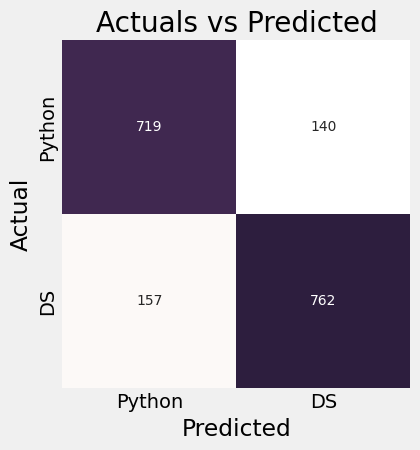

In [ ]:
plot_confusion(y_test, y_pred)

## Сравнение различных моделей для метода TF-IDF

In [ ]:
def get_models():
    return {'RandomForest': RandomForestClassifier(bootstrap=True,
                                                   n_estimators=100,
                                                   n_jobs=-1),
           "GB":GradientBoostingClassifier(n_estimators=100),
            "kNN":KNeighborsClassifier(),
            "LogisticRegression":LogisticRegression(),
            "SVC":SVC(kernel='rbf')}



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_TFIDF = vectorizer.fit_transform(X_train)
X_test_TFIDF = vectorizer.transform(X_test)

metrics = {}
models = get_models()
for name, model in models.items():
    print(name)
    clf = model.fit(X_train_TFIDF, y_train)
    y_predict_TFIDF = clf.predict(X_test_TFIDF)
    score = f1_score(y_predict_TFIDF, y_test)
    metrics[name] = score


RandomForest
GB
kNN
LogisticRegression
SVC


In [ ]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index').reset_index()
df_metrics.columns = ['model', 'f1_score']

In [ ]:
df_metrics

,model,f1_score
0,RandomForest,0.810755
1,GB,0.775927
2,kNN,0.825248
3,LogisticRegression,0.836903
4,SVC,0.852696


##Выводы:

Из сравнения моделей можно сделать предположение что варианты на решающих деревьях работают хуже

SVM с rbf ядром работает лучше

Логистическая регрессия тоже очень неплохо

Опять таки непонятно, обусловлены ли различия в выборках применением больших языковых моделей

**Можно лишь утверждать, что студенческие работы за 2019 г. отличаются от работ за 2024г. составом словаря, использованного студентами**

**Сохраним логистическую модель для работы**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       752
           1       0.84      0.81      0.83       847

    accuracy                           0.82      1599
   macro avg       0.82      0.82      0.82      1599
weighted avg       0.82      0.82      0.82      1599



In [ ]:
# Сохранить модель
from joblib import dump, load
dump(clf, './logistic_reg_model.joblib') # работа с процессами модели joblib.dump файл

['./logistic_reg_model.joblib']

In [ ]:
# сохранить векторизованную модель API
# *.pkl - расширение файла, который используется в Python для сохранения объектов
# Объекты могут быть любыми: числами, строками, списками, словарями, классами и т.д.
# Все, что можно создать в Python, можно сохранить в pkl файле.
dump(vectorizer, 'vectorizer_tfidf.pkl', compress=True) # сжвтый файл работы с моделью, h5, hdf5 - виды файлов по выгрузке

['vectorizer_tfidf.pkl']

##  Используем числовые признаки  (из  ноутбука -  create_dataset_extract_features.ipynb)

Пояснения к признакам приведены в ноутбуке "create_dataset_extract_features.ipynb"

-------

 **Вот обозначения реализованных признаков:**

Количество символов **char_count**

Количество слов **word_count**

Количество предложений **sentence_count**

Средняя длина слова **avg_word_length**

Средняя длина предложения **avg_sentence_length**

TTR (Type-Token Ratio) **ttr**

Индекс лексического разнообразия Хердана **herdan_index**

Индекс лексического разнообразия Юла **yule_index**

Частота использования служебных слов **function_words_ratio**

Среднее количество знаков препинания на предложение **avg_punctuation_per_sentence**

Средняя глубина синтаксического дерева предложений **avg_tree_depth**

Соотношение различных частей речи - **пояснения ниже**

Энтропия распределения символов **char_entropy**

Энтропия распределения слов **word_entropy**

Индекс удобочитаемости Флеша-Кинкейда (адаптированный для русского языка) **flesch_kincaid_grade**

Индекс туманности Ганнинга (адаптированный для русского языка) **gunning_fog_index**

Частота повторения слов **word_repetition_frequency**

**Соотношение различных частей речи**

**pos_ratio_ADJ** - Доля прилагательных в тексте

**pos_ratio_ADP** - Доля предлогов в тексте

**pos_ratio_ADV** - Доля наречий в тексте

**pos_ratio_AUX** - Доля вспомогательных глаголов в тексте

**pos_ratio_CONJ** - Доля союзов в тексте (устаревший тег, заменен на CCONJ и SCONJ)

**pos_ratio_CCONJ** - Доля сочинительных союзов в тексте

**pos_ratio_DET** - Доля определителей (артиклей, указательных местоимений) в тексте

**pos_ratio_INTJ** - Доля междометий в тексте

**pos_ratio_NOUN** - Доля существительных в тексте

**pos_ratio_NUM** - Доля числительных в тексте

**pos_ratio_PART** - Доля частиц в тексте

**pos_ratio_PRON** - Доля местоимений в тексте

**pos_ratio_PROPN** - Доля имен собственных в тексте

**pos_ratio_PUNCT** - Доля знаков пунктуации в тексте

**pos_ratio_SCONJ** - Доля подчинительных союзов в тексте

**pos_ratio_SYM** - Доля символов в тексте (например, $, %, &)

**pos_ratio_VERB** - Доля глаголов в тексте

**pos_ratio_X** - Доля прочих слов, не попадающих в другие категории

**pos_ratio_EOL** - Доля символов конца строки (не стандартный тег POS)

**pos_ratio_SPACE** - Доля пробелов в тексте (не стандартный тег POS)

In [ ]:
# основные по работе с данными (таблицы, математика)
import pandas as pd
import numpy as np

In [ ]:
# графики
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5) # размер графиков
plt.style.use('fivethirtyeight') # стиль графиков

# модели
import sklearn

In [ ]:
from sklearn.model_selection import train_test_split # делим на тестовую и тренировочную
from sklearn.feature_extraction.text import CountVectorizer # мешок слов


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report # метрика точности, f1 мера, матрица ошибок и отчёт по классификации
from sklearn import model_selection # выбор модели и оценка параметров (можно загрузить несколько моделей)
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # бустинг, случайный лес
from sklearn.svm import SVC # метод SVM, загружаем с ядром rbf https://scikit-learn.ru/1-4-support-vector-machines/
from sklearn.neighbors import KNeighborsClassifier # к ближайших соседей

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

##Скачиваем файл с признаками и меткой

In [ ]:
!gdown 13Why_EdaN-Q5poFdlF3f1ZCwYDrK9DkQ

Downloading...
From: https://drive.google.com/uc?id=13Why_EdaN-Q5poFdlF3f1ZCwYDrK9DkQ
To: /content/not_null_result6_oll_data.csv
100% 10.7M/10.7M [00:00<00:00, 37.2MB/s]


In [ ]:
# Файл с данными
df = pd.read_csv('not_null_result6_oll_data.csv')

In [ ]:
df

,file_number,paragraph_number,content,label,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,ttr,...,pos_ratio_NUM,pos_ratio_PART,pos_ratio_PRON,pos_ratio_PROPN,pos_ratio_PUNCT,pos_ratio_SCONJ,pos_ratio_SYM,pos_ratio_VERB,pos_ratio_X,pos_ratio_SPACE
0,1,1,Введение\n\n\n целью выпускной квалификаци...,0,1294,159,6,6.880503,26.500000,0.761006,...,0.000000,0.006024,0.018072,0.030120,0.138554,0.000000,0.0,0.150602,0.000000,0.042169
1,1,2,Эти работы представлены ниже. Не стоит считать...,0,565,84,3,5.869048,28.000000,0.821429,...,0.000000,0.011765,0.000000,0.000000,0.152941,0.023529,0.0,0.141176,0.000000,0.000000
2,1,3,"В компьютерных играх, как правило, игровая сит...",0,694,106,5,5.500000,21.200000,0.726415,...,0.000000,0.037383,0.000000,0.009346,0.102804,0.009346,0.0,0.093458,0.000000,0.009346
3,1,4,"Сразу стоит отметить, что на сегодняшний день ...",0,698,97,5,5.989691,19.400000,0.793814,...,0.009709,0.009709,0.019417,0.000000,0.174757,0.009709,0.0,0.087379,0.000000,0.058252
4,1,5,"Вовторых, разработчики не прекращают своих экс...",0,716,111,6,5.549550,18.500000,0.783784,...,0.017857,0.017857,0.053571,0.026786,0.151786,0.008929,0.0,0.116071,0.026786,0.008929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,100,64,Под воздействием внешних условий они превращаю...,1,799,112,8,6.267857,14.000000,0.741071,...,0.000000,0.000000,0.044643,0.000000,0.142857,0.000000,0.0,0.125000,0.000000,0.000000
5921,100,65,В современных настольных пк таких компонентов ...,1,806,125,13,5.600000,9.615385,0.752000,...,0.000000,0.000000,0.024000,0.016000,0.144000,0.016000,0.0,0.144000,0.000000,0.000000
5922,100,66,"Стоимость таких услуг не велика, и это, безусл...",1,845,113,5,6.601770,22.600000,0.681416,...,0.000000,0.008772,0.035088,0.000000,0.131579,0.017544,0.0,0.131579,0.000000,0.008772
5923,100,67,Она может быть использована как пример для раз...,1,1051,138,5,6.724638,27.600000,0.652174,...,0.000000,0.000000,0.028169,0.000000,0.126761,0.014085,0.0,0.084507,0.000000,0.028169


Удаляем столбцы не использующиеся для классификации

In [ ]:
df = df.drop(['file_number', 'paragraph_number', 'content'], axis=1)

In [ ]:
df

,label,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,ttr,herdan_index,yule_index,function_words_ratio,...,pos_ratio_NUM,pos_ratio_PART,pos_ratio_PRON,pos_ratio_PROPN,pos_ratio_PUNCT,pos_ratio_SCONJ,pos_ratio_SYM,pos_ratio_VERB,pos_ratio_X,pos_ratio_SPACE
0,0,1294,159,6,6.880503,26.500000,0.761006,0.946120,63.689197,0.144654,...,0.000000,0.006024,0.018072,0.030120,0.138554,0.000000,0.0,0.150602,0.000000,0.042169
1,0,565,84,3,5.869048,28.000000,0.821429,0.955604,100.401606,0.226190,...,0.000000,0.011765,0.000000,0.000000,0.152941,0.023529,0.0,0.141176,0.000000,0.000000
2,0,694,106,5,5.500000,21.200000,0.726415,0.931460,122.192273,0.245283,...,0.000000,0.037383,0.000000,0.009346,0.102804,0.009346,0.0,0.093458,0.000000,0.009346
3,0,698,97,5,5.989691,19.400000,0.793814,0.949526,100.945017,0.175258,...,0.009709,0.009709,0.019417,0.000000,0.174757,0.009709,0.0,0.087379,0.000000,0.058252
4,0,716,111,6,5.549550,18.500000,0.783784,0.948270,103.194103,0.216216,...,0.017857,0.017857,0.053571,0.026786,0.151786,0.008929,0.0,0.116071,0.026786,0.008929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,1,799,112,8,6.267857,14.000000,0.741071,0.936493,112.612613,0.187500,...,0.000000,0.000000,0.044643,0.000000,0.142857,0.000000,0.0,0.125000,0.000000,0.000000
5921,1,806,125,13,5.600000,9.615385,0.752000,0.940969,148.387097,0.232000,...,0.000000,0.000000,0.024000,0.016000,0.144000,0.016000,0.0,0.144000,0.000000,0.000000
5922,1,845,113,5,6.601770,22.600000,0.681416,0.918860,135.903919,0.176991,...,0.000000,0.008772,0.035088,0.000000,0.131579,0.017544,0.0,0.131579,0.000000,0.008772
5923,1,1051,138,5,6.724638,27.600000,0.652174,0.913249,106.844388,0.159420,...,0.000000,0.000000,0.028169,0.000000,0.126761,0.014085,0.0,0.084507,0.000000,0.028169


In [ ]:
df.to_csv('gotov_df.csv', index=False)

In [ ]:
!gdown 1CYtwcQYeKtQF1cAsfzQS3rT_P23-fW_j

Downloading...
From: https://drive.google.com/uc?id=1CYtwcQYeKtQF1cAsfzQS3rT_P23-fW_j
To: /content/gotov_df.csv
100% 2.68M/2.68M [00:00<00:00, 142MB/s]


In [ ]:
df = pd.read_csv('gotov_df.csv')

In [ ]:
df

,label,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,ttr,herdan_index,yule_index,function_words_ratio,...,pos_ratio_NUM,pos_ratio_PART,pos_ratio_PRON,pos_ratio_PROPN,pos_ratio_PUNCT,pos_ratio_SCONJ,pos_ratio_SYM,pos_ratio_VERB,pos_ratio_X,pos_ratio_SPACE
0,0,1294,159,6,6.880503,26.500000,0.761006,0.946120,63.689197,0.144654,...,0.000000,0.006024,0.018072,0.030120,0.138554,0.000000,0.0,0.150602,0.000000,0.042169
1,0,565,84,3,5.869048,28.000000,0.821429,0.955604,100.401606,0.226190,...,0.000000,0.011765,0.000000,0.000000,0.152941,0.023529,0.0,0.141176,0.000000,0.000000
2,0,694,106,5,5.500000,21.200000,0.726415,0.931460,122.192273,0.245283,...,0.000000,0.037383,0.000000,0.009346,0.102804,0.009346,0.0,0.093458,0.000000,0.009346
3,0,698,97,5,5.989691,19.400000,0.793814,0.949526,100.945017,0.175258,...,0.009709,0.009709,0.019417,0.000000,0.174757,0.009709,0.0,0.087379,0.000000,0.058252
4,0,716,111,6,5.549550,18.500000,0.783784,0.948270,103.194103,0.216216,...,0.017857,0.017857,0.053571,0.026786,0.151786,0.008929,0.0,0.116071,0.026786,0.008929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,1,799,112,8,6.267857,14.000000,0.741071,0.936493,112.612613,0.187500,...,0.000000,0.000000,0.044643,0.000000,0.142857,0.000000,0.0,0.125000,0.000000,0.000000
5921,1,806,125,13,5.600000,9.615385,0.752000,0.940969,148.387097,0.232000,...,0.000000,0.000000,0.024000,0.016000,0.144000,0.016000,0.0,0.144000,0.000000,0.000000
5922,1,845,113,5,6.601770,22.600000,0.681416,0.918860,135.903919,0.176991,...,0.000000,0.008772,0.035088,0.000000,0.131579,0.017544,0.0,0.131579,0.000000,0.008772
5923,1,1051,138,5,6.724638,27.600000,0.652174,0.913249,106.844388,0.159420,...,0.000000,0.000000,0.028169,0.000000,0.126761,0.014085,0.0,0.084507,0.000000,0.028169


#Делим данные на train и test и обучаем модели

In [ ]:
X = df.drop('label', axis=1)
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Функция для построения моделей

In [ ]:
def get_models():
    return {
        'RandomForest': RandomForestClassifier(bootstrap=True, n_estimators=100, n_jobs=-1),
        "GB": GradientBoostingClassifier(n_estimators=100),
        "kNN": Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ]),
        "LogisticRegression": Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression())
        ]),
        "SVC": Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC(kernel='rbf'))
        ])
    }

Обучаем, оцениваем качество

In [ ]:
metrics = {}
models = get_models()

for name, model in models.items():
    print(f"Обучение модели: {name}")
    clf = model.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    score = f1_score(y_test, y_predict)
    metrics[name] = score
    print(f"F1-score для {name}: {score:.4f}")


Обучение модели: RandomForest
F1-score для RandomForest: 0.6825
Обучение модели: GB
F1-score для GB: 0.6999
Обучение модели: kNN
F1-score для kNN: 0.6804
Обучение модели: LogisticRegression
F1-score для LogisticRegression: 0.7030
Обучение модели: SVC
F1-score для SVC: 0.7157


In [ ]:
# Вывод результатов
print("\nИтоговые результаты:")
for name, score in metrics.items():
    print(f"{name}: {score:.4f}")



Итоговые результаты:
RandomForest: 0.6825
GB: 0.6999
kNN: 0.6804
LogisticRegression: 0.7030
SVC: 0.7157


In [ ]:
# Определение лучшей модели
best_model = max(metrics, key=metrics.get)
print(f"\nЛучшая модель: {best_model} с F1-score: {metrics[best_model]:.4f}")


Лучшая модель: SVC с F1-score: 0.7157


#Важность признаков

Логистическая регрессия предоставляет коэффициенты для каждого признака, которые можно интерпретировать как меру важности. Абсолютные значения этих коэффициентов указывают на относительную важность признаков.

Топ-10 важных признаков для логистической регрессии:
                 feature  importance
0             char_count    1.774514
1             word_count    0.902274
14     gunning_fog_index    0.830812
11          char_entropy    0.644759
13  flesch_kincaid_grade    0.459170
20       pos_ratio_CCONJ    0.445553
28       pos_ratio_PUNCT    0.443921
12          word_entropy    0.331404
23        pos_ratio_NOUN    0.311684
6           herdan_index    0.259272


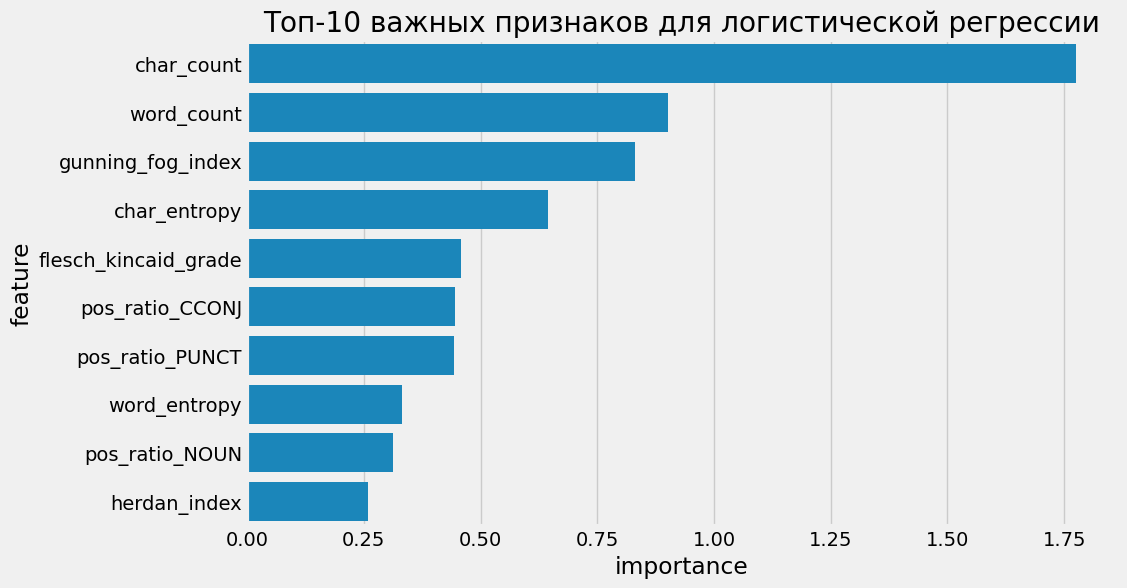

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Предполагаем, что у вас уже есть X_train и y_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Получение важности признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': abs(log_reg.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Вывод топ-10 важных признаков
print("Топ-10 важных признаков для логистической регрессии:")
print(feature_importance.head(10))

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Топ-10 важных признаков для логистической регрессии')
plt.show()

#Еще раз SVC

Точность модели: 0.7063

Матрица ошибок:
[[399 171]
 [177 438]]

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       570
           1       0.72      0.71      0.72       615

    accuracy                           0.71      1185
   macro avg       0.71      0.71      0.71      1185
weighted avg       0.71      0.71      0.71      1185



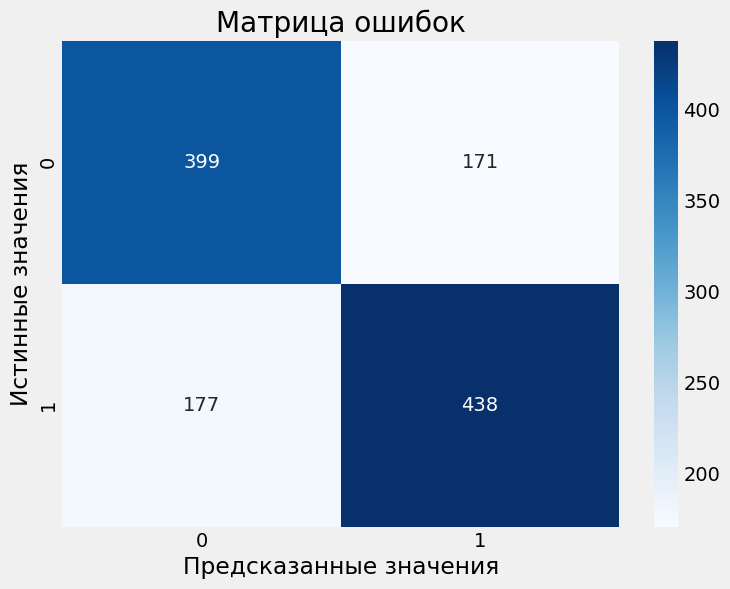

In [ ]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели SVC с ядром RBF
svc_rbf = SVC(kernel='rbf', random_state=42)
svc_rbf.fit(X_train_scaled, y_train)

# Предсказание на тестовом наборе
y_pred = svc_rbf.predict(X_test_scaled)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Вывод результатов
print(f"Точность модели: {accuracy:.4f}")
print("\nМатрица ошибок:")
print(conf_matrix)
print("\nОтчет о классификации:")
print(class_report)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

SVM не предоставляет прямого способа определения важности признаков, особенно для нелинейных ядер

Но для нелинейных ядер SVM ( RBF)  можно использовать методы выбора признаков, такие как рекурсивное исключение признаков (Recursive Feature Elimination) или методы на основе перестановок (Permutation Importance)

Воспользуемся методом на основе перестановок

Топ-10 важных признаков для SVM (Permutation Importance):
                 feature  importance
13  flesch_kincaid_grade    0.054768
11          char_entropy    0.039916
28       pos_ratio_PUNCT    0.034346
23        pos_ratio_NOUN    0.027764
20       pos_ratio_CCONJ    0.026414
0             char_count    0.025570
10        avg_tree_depth    0.024135
14     gunning_fog_index    0.011983
32           pos_ratio_X    0.010802
18         pos_ratio_ADV    0.009958


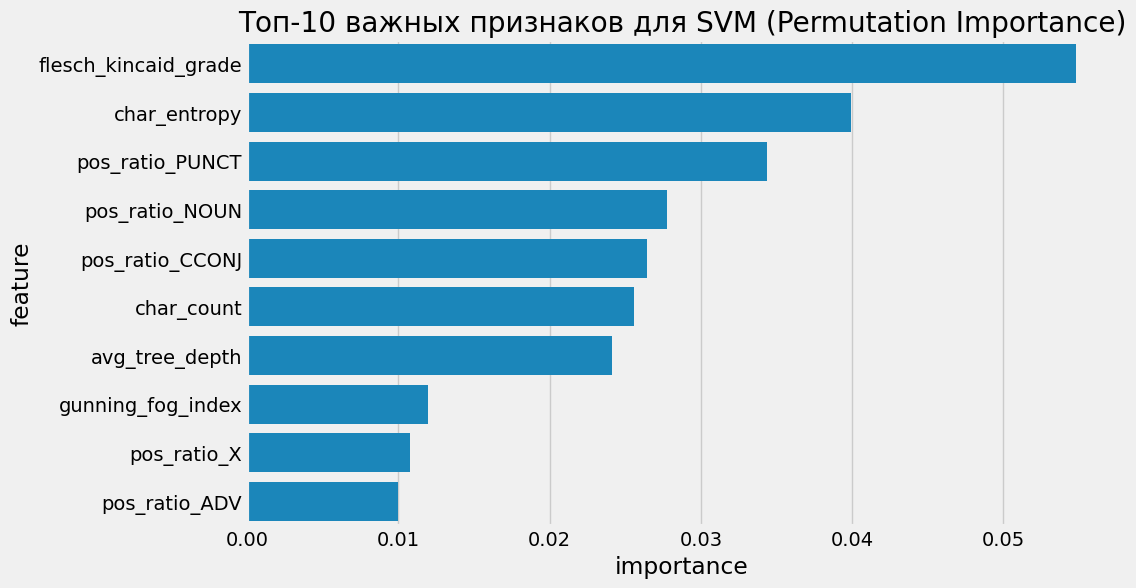

In [ ]:
from sklearn.inspection import permutation_importance

# У нас уже есть обученная модель SVM и тестовые данные
result = permutation_importance(svc_rbf, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Создание DataFrame с результатами
feature_importance_perm = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
})
feature_importance_perm = feature_importance_perm.sort_values('importance', ascending=False)

# Вывод топ-10 важных признаков
print("Топ-10 важных признаков для SVM (Permutation Importance):")
print(feature_importance_perm.head(10))

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_perm.head(10))
plt.title('Топ-10 важных признаков для SVM (Permutation Importance)')
plt.show()

##Выводы

Метрики качества моделей на датасете с выбранными статистическими признаками, получились немного хуже, чем для признаков TF-IDF

Можно еще будет попробовать подобрать гиперпараметры для моделей

Но в данном случае использованные для классификации признаки отражают не только частотные характеристики слов, использованных студентами в своих работах. Поэтому возможно могут позволить выявить закономерности, связанные с применением больших языковых моделей

Наилучшие результаты показали - логистическая регрессия и SVC с ядром  rbf

В топ-10 важных признаков для обоих  моделей попали 6 признаков-

**flesch_kincaid_grade** Индекс удобочитаемости Флеша-Кинкейда (адаптированный для русского языка)

**char_entropy** Энтропия распределения символов

**pos_ratio_PUNCT** - Доля знаков пунктуации в тексте

**pos_ratio_NOUN** - Доля существительных в тексте

**pos_ratio_CCONJ** - Доля сочинительных союзов в тексте

**gunning_fog_index** Индекс туманности Ганнинга (адаптированный для русского языка)

Возможно на эти признаки следует обратить внимание в дальнейшем исследовании

